In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
%cd /content/gdrive/MyDrive/GTC/OTP/southern_ocean

Mounted at /content/gdrive
/content/gdrive/MyDrive/GTC/OTP/southern_ocean


In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import pickle
import sys; sys.path.append("../models")
import utils
import train
from RNN import RNN
from GRU import GRU
from LSTM import LSTM

import xarray as xr
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error as _mape
import matplotlib.pyplot as plt

import torch as t
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm, trange
from IPython.display import clear_output

device = "cuda" if t.cuda.is_available() else "cpu"
t.manual_seed(123456)

In [3]:
gdrive = "../.."
data_home = f"{gdrive}/ecco_data_minimal"
sections = ["26N", "30S", "55S", "60S"]
coordinates = ["time", "latitude", "longitude"]
vars = ["SSH", "SST", "SSS", "OBP", "ZWS"]

data_vars = ["OBP", "ZWS"]
keep_coords = ["time", "latitude", "longitude"]
history = 3
n_layers = 10
d_model = 16
# function to extract closes latitude in ecco data
ecco_lat = lambda x: -float(x[:-1])+0.25

moc_files = os.listdir(f"{gdrive}/moc/so")
so_lats = [-float(f[:5]) for f in moc_files]
full_moc = []
for f in moc_files:
    infile = open(f"{gdrive}/moc/so/{f}", "rb")
    full_moc.append(pickle.load(infile)); infile.close()
full_moc = np.array(full_moc)

full_data = xr.open_dataset(f"{data_home}/southern_ocean.nc").transpose(*coordinates)
full_data = full_data.sel(latitude=so_lats)

In [4]:
trainval_split = int(0.7*full_data.sizes["time"])
valtest_split = int(0.8*full_data.sizes["time"])

model = LSTM(n_inputs=720*len(data_vars),
            n_outputs=1,
            n_layers=n_layers,
            d_hidden=d_model,
            d_model=d_model,
            dropout=0.,
            device=device).to(device)
model.train()

train.batch_size = 128
train.max_iters = 25000
train.lr = 1e-3
train.weight_decay = 1e-5

In [5]:
pp_data = utils.reshape_inputs(full_data,
                               keep_coords=keep_coords,
                               data_vars=data_vars,
                               history=history,
                               return_pt=True, verbose=True)
n_time, n_history, n_lat, n_lon, n_feature = pp_data.shape
# (time, latitude, history, signal, longitude)
pp_data = t.permute(pp_data, (0, 2, 1, 4, 3))
moc = full_moc[:, -pp_data.shape[0]:].T
n_time, n_lat, n_history, n_signal, n_lon = pp_data.shape
pp_data = pp_data.reshape(n_time, n_lat, n_history, -1)
n_feature = pp_data.shape[-1]

axes: ['time', 'history', 'latitude', 'longitude', 'feature']
variables: ['OBP', 'ZWS']
shape: (310, 3, 102, 720, 2)


In [6]:
X_train = pp_data[:trainval_split, ...].reshape(-1, n_history, n_feature).to(device)
X_val = pp_data[trainval_split:valtest_split, ...].reshape(-1, n_history, n_feature).to(device)
X_test = pp_data[valtest_split:, ...].reshape(-1, n_history, n_feature).to(device)
y_train = t.Tensor(moc[:trainval_split].flatten()).to(device)
y_val = t.Tensor(moc[trainval_split:valtest_split].flatten()).to(device)
y_test = t.Tensor(moc[valtest_split:].flatten()).to(device)

# local standardisation
m = t.Tensor(np.nanmean(X_train.cpu().numpy(), axis=tuple(np.arange(X_train.ndim-1)))).to(device)
s = t.Tensor(np.nanstd(X_train.cpu().numpy(), axis=tuple(np.arange(X_train.ndim-1)))).to(device)
X_train = (X_train - m[..., :]) / s[..., :]
X_val = (X_val - m[..., :]) / s[..., :]
X_test = (X_test - m[..., :]) / s[..., :]

X_train = t.nan_to_num(X_train, 0.)
X_val = t.nan_to_num(X_val, 0.)
X_test = t.nan_to_num(X_test, 0.)

model, train_loss, val_loss = train.train_model(model, X_train, y_train, X_val=X_val, y_val=y_val, early_stopping=False, eval_iter=1000)

device: cuda
116273 parameters.
----------
Training Loss: 213.61770629882812
Validation Loss: 180.5728759765625
----------
Training Loss: 26.264739990234375
Validation Loss: 22.491653442382812
----------
Training Loss: 10.945032119750977
Validation Loss: 11.310036659240723
----------
Training Loss: 4.492713928222656
Validation Loss: 9.638564109802246
----------
Training Loss: 3.56803560256958
Validation Loss: 9.315019607543945
----------
Training Loss: 3.1608338356018066
Validation Loss: 11.267889976501465
----------
Training Loss: 3.3430609703063965
Validation Loss: 10.068657875061035
----------
Training Loss: 3.344637393951416
Validation Loss: 9.293389320373535
----------
Training Loss: 2.442229747772217
Validation Loss: 9.113337516784668
----------
Training Loss: 2.0588817596435547
Validation Loss: 9.861639976501465
----------
Training Loss: 3.8978350162506104
Validation Loss: 10.12409496307373
----------
Training Loss: 1.4881632328033447
Validation Loss: 9.137353897094727
---------

Median RMSE: 5.49
Median MAPE: 43.49
Median MAPE_0.5: 40.47
Median MAPE (<1000): 42.4



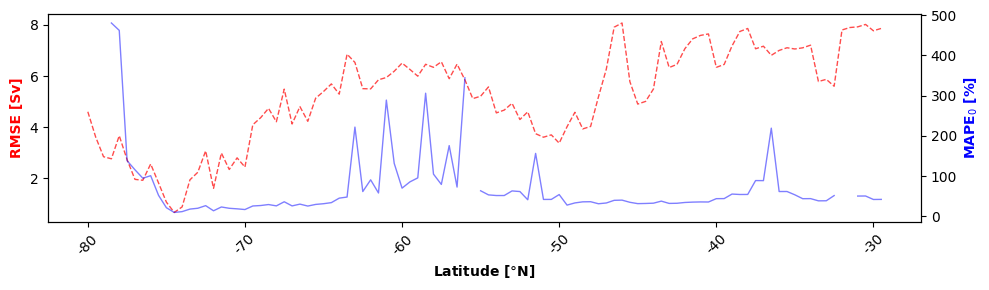

In [9]:
def _mape_thresh(true, pred, thresh=0.5):
    ixs = (t.abs(true) > thresh).nonzero().flatten()
    if len(ixs) == 0:
        return np.nan
    else:
        true_ = true[ixs].cpu().detach().numpy()
        pred_ = pred[ixs].cpu().detach().numpy()
        return _mape(true_, pred_)*100

model.eval()
test_predictions = model(X_test)
pred_lat = test_predictions.reshape(-1, n_lat).T
true_lat = y_test.reshape(-1, n_lat).T
losses = [F.mse_loss(p, t).item() for p, t in zip(pred_lat, true_lat)]
rmse = [np.sqrt(l) for l in losses]
mape = [_mape(t.cpu().detach().numpy(), p.cpu().detach().numpy())*100 for t, p in zip(true_lat, pred_lat)]
mape_thresh = [_mape_thresh(t, p) for t, p in zip(true_lat, pred_lat)]
mape_thresh = np.array(mape_thresh)[~np.isnan(mape_thresh)]

print(f"Median RMSE: {round(np.median(rmse), 2)}")
print(f"Median MAPE: {str(round(np.median(mape), 2))}")
print(f"Median MAPE_0.5: {round(np.median(mape_thresh), 2)}")
print(f"Median MAPE (<1000): {str(round(np.median([m for m in mape if m < 1000]), 2))}")
print()

mape = [m if m < 1000 else np.nan for m in mape]
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(rmse, color="red", linewidth=1, linestyle="--", alpha=0.7)
ax.set_ylabel("RMSE [Sv]", color="red", weight="bold")
ax2 = ax.twinx()
ax2.plot(mape, color="blue", linewidth=1, alpha=0.5)
ax2.set_ylabel("MAPE$_{0}$ [%]", color="blue", weight="bold")
lat_labels = [f"{str(s+0.25)[:-2]}" for s in so_lats]
ax.set_xticks(np.arange(0, len(so_lats), 20), lat_labels[::20], rotation=45, fontsize=10)
ax.set_xlabel("Latitude [$\\degree$N]", weight="bold")
plt.tight_layout()
plt.savefig("performance_LSTM.png", dpi=400)
plt.show()

In [10]:
t.save(model.state_dict(), "model_LSTM.pt")